In [1]:
from transformers import AutoTokenizer, RobertaModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('..')
import utils

In [2]:
data = pd.read_json('../data/predictions/base.json')

tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")
model = RobertaModel.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")
model = utils.FakeModel(model, tokenizer=tokenizer)
model = utils.LightningModel.load_from_checkpoint('../models/baseline/lr_1e-6_sch_0.8-step=868.ckpt', model=model, tokenizer=tokenizer)
model = model.model

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


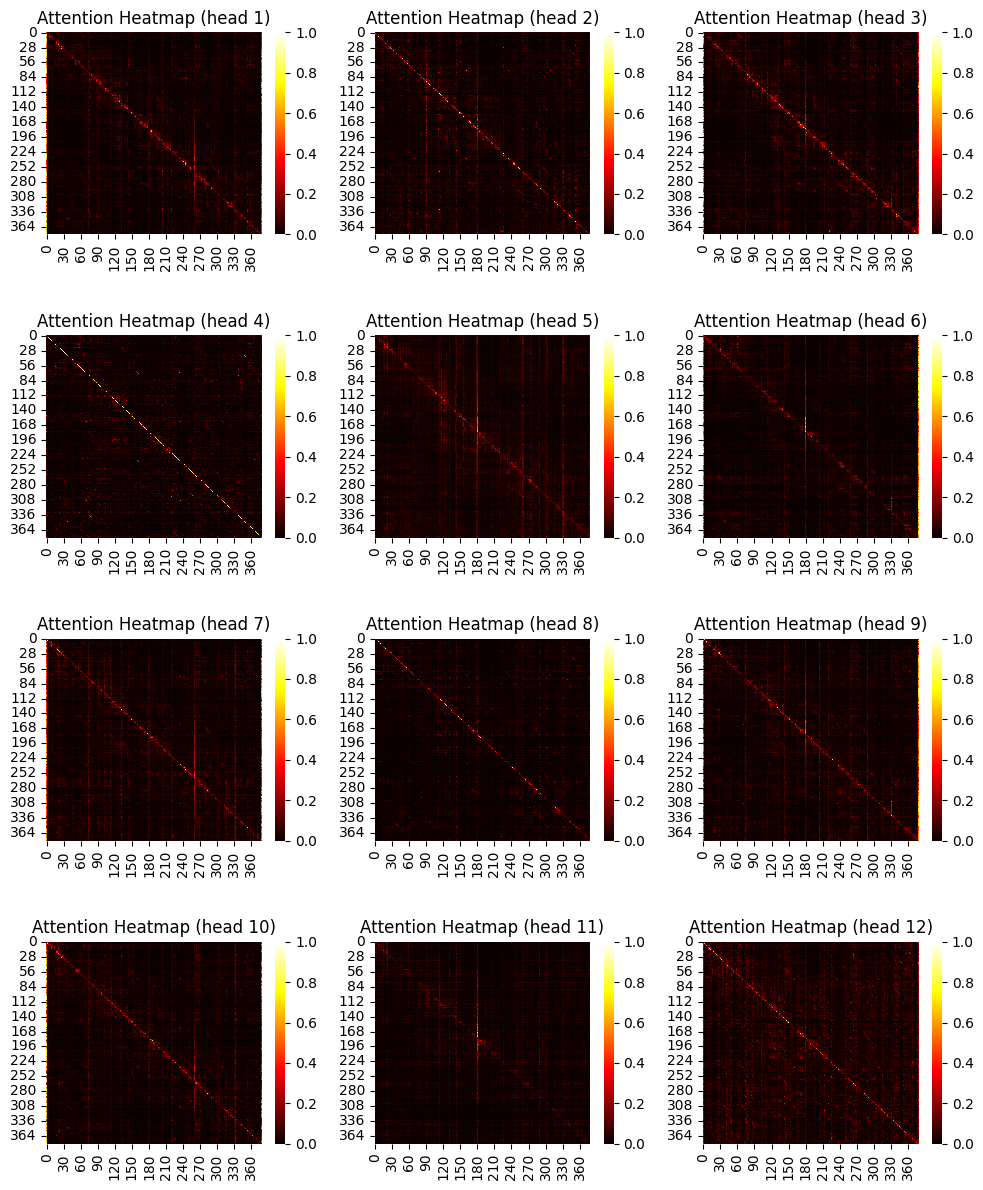

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(attentions):
    plt.figure(figsize=(10,12))  # Increase the size of the plot
    for i in range(len(attentions)):
        # Get the attention values for the first position
        attention_values = np.sqrt(attentions[-1][0,i,:,:].detach().cpu().numpy())

        plt.subplot(len(attentions) // 3, 3, i + 1,)
        sns.heatmap(attention_values, cmap='hot', cbar=True, vmax=1, vmin=0)
        plt.title(f'Attention Heatmap (head {i+1})')
        #plt.xlabel('Sequence Position')
        #plt.ylabel('Head')
        #plt.ylim(0, attention_values.shape[0])  # Increase the y-axis scale
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

idx = 261
_, attentions = model(data['text'][idx], output_attentions=True)
plot_attention(attentions)

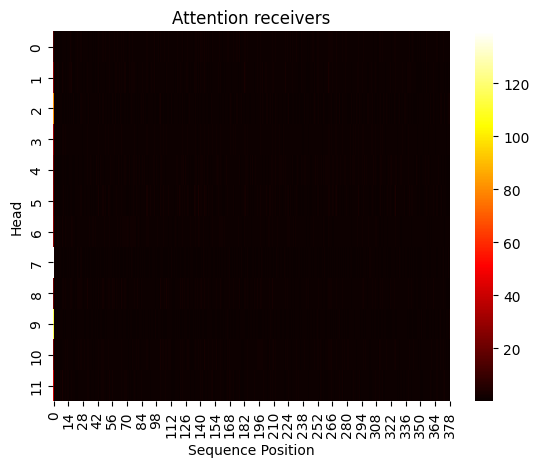

Top words
0 [CLS] ĠOMS Ġletal SegÃºn Ġinfec
1 [CLS] Un Su En ĠEN
2 [CLS] %), [SEP] Ġsemanas Ġdirecto
3 [CLS] Ġbrote Ġgripe Ġincu Ġavisa
4 [CLS] Ġfluidos Ġque Ġque Ġque
5 [CLS] Ġfrecuentemente Ġfrecuentemente ĠprÃ¡cticamente Ġavisa
6 [CLS] pa ĠEN Ġfrecuentemente ĠDE
7 [CLS] . . . .
8 [CLS] Ġcontagio Ġvacuna Ġpand %),
9 [CLS] [SEP] idad ĠtravÃ©s Ġgravedad
10 [CLS] SegÃºn %), Ġfrecuentemente ĠtransmisiÃ³n
11 [CLS] ĠDE ĠTimes Ġcontacto ĠMundial


In [41]:
def top_words(attentions, tokenizer, text):
    # Get the attention values for the first position
    attention_values = attentions.detach().cpu().numpy()
    attention_values = np.sum(attention_values, axis=1)
    tokens = tokenizer.tokenize(text)
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    idxs = np.argsort(attention_values, axis=1)[:,-5:]
    idxs = idxs[:,::-1]
    print('Top words')
    for i, row in enumerate(idxs):
        print(' '.join([str(i)] + [tokens[i] for i in row]))

idx = 261
_, attentions = model(data['text'][idx], output_attentions=True)
top_words(attentions[0][0], tokenizer, data['text'][idx])

In [4]:
import torch
from einops import reduce
from tqdm import tqdm

def get_global_attn(data):
    attentions = torch.zeros(12,12,512)  # keep this on CPU
    batch_size = 8 # try lowering batch size
    for i in tqdm(range(0, len(data), batch_size)):
        batch = data['text'][i:i+batch_size].to_list()
        with torch.no_grad():
            _, attn = model(batch, output_attentions=True)
        #attn = [a[:,:,0,:].to('cpu') for a in attn]
        attn = torch.stack(attn).cpu()[:,:,:,0,:]
        attn = torch.nn.functional.pad(attn, (0, 512 - attn.shape[-1]))
        attn = torch.sum(attn, dim=1)
        attentions += attn
    #attentions /= len(data)
    return attentions
attentions = get_global_attn(data[data['predictions'] == 'Fake'])
print(attentions.shape)

100%|██████████| 127/127 [00:08<00:00, 15.19it/s]

torch.Size([12, 12, 512])


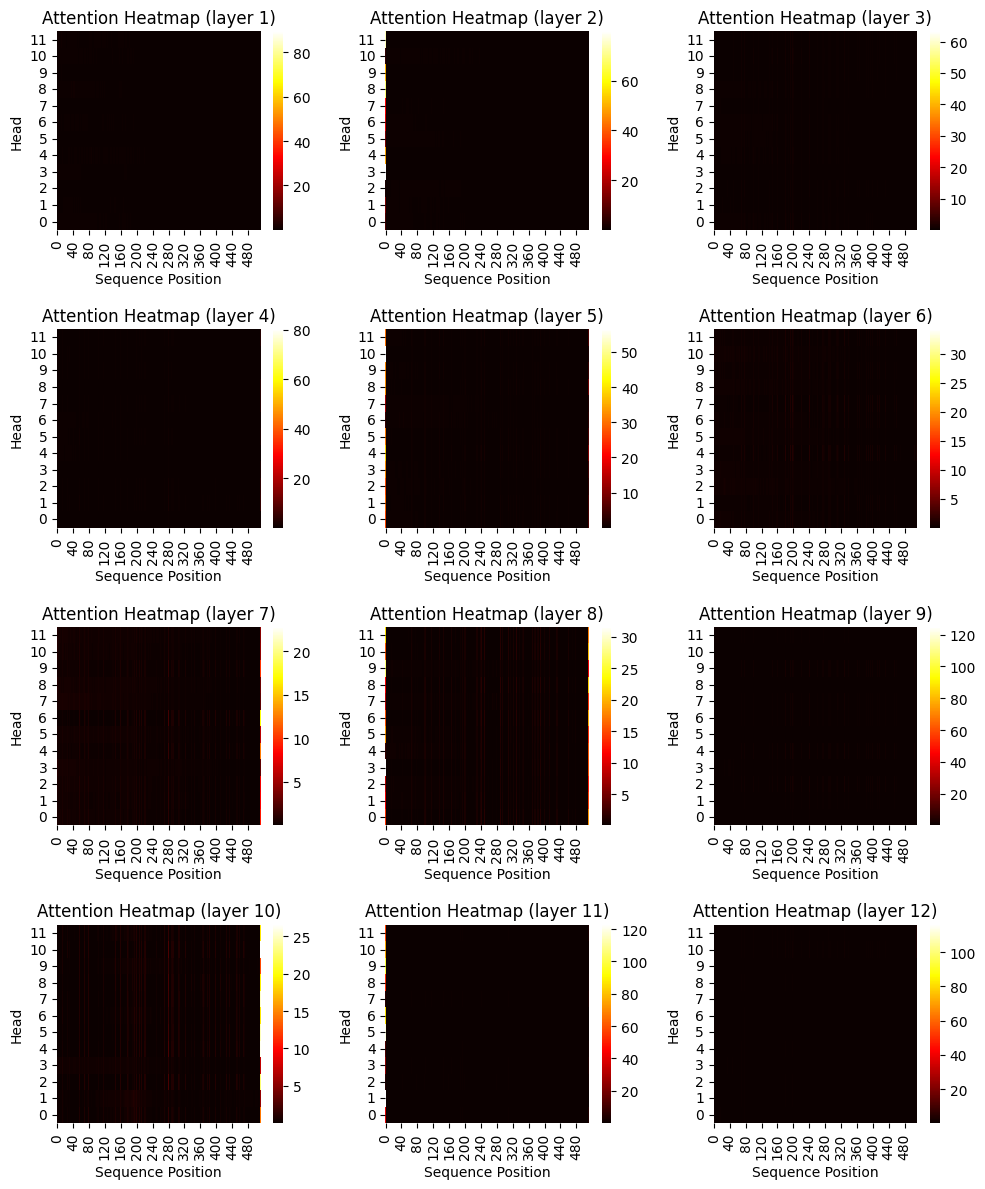

In [5]:
plt.figure(figsize=(10,12))  # Increase the size of the plot
for i in range(len(attentions)):
    # Get the attention values for the first position
    attention_values = attentions[i].detach().cpu().numpy()

    plt.subplot(len(attentions) // 3, 3, i + 1,)
    sns.heatmap(attention_values, cmap='hot', cbar=True)#, vmax=1, vmin=0)
    plt.title(f'Attention Heatmap (layer {i+1})')
    plt.xlabel('Sequence Position')
    plt.ylabel('Head')
    plt.ylim(0, attention_values.shape[0])  # Increase the y-axis scale
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()